In [4]:

import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
import networkx as nx
import yfinance as yf

import DyGraph as dg
import matplotlib.pyplot as plt
import tqdm
import scipy
import pickle
import seaborn as sns
import datetime

# ETF portfolio case study

Run CaseStudyETF.py and CaseStudy_static.py for the results. Note group-t, skew-group-t, block-wise and perturbed-node will take some time

In [5]:



dgaussian_ew = dict()
dgaussian_ridge = dict()
dgaussian_gr = dict()
dgaussian_bwr = dict()
dgaussian_pn = dict()

dt_ew = dict()
dt_ridge = dict()
dt_gr = dict()
dt_bwr = dict()
dt_pn = dict()

dgt_ew = dict()
dsgt_ew = dict()

with open(f'data/static_gaussian_nr_quad_10_etf_k3.pkl', 'rb') as handle:
    sgaussian = pickle.load(handle)
with open(f'data/static_t_nr_quad_10_etf_k3.pkl', 'rb') as handle:
    st = pickle.load(handle)
with open(f'data/ledoitwolf_nr_quad_10_etf_k3.pkl', 'rb') as handle:
    ledoitwolf = pickle.load(handle)
with open(f'data/empirical_nr_quad_10_etf_k3.pkl', 'rb') as handle:
    empirical = pickle.load(handle)
with open(f'data/group-t_nr_quad_10_etf_k3.pkl', 'rb') as handle:
    sgt = pickle.load(handle)
with open(f'data/skew-group-t_nr_quad_10_etf_k3.pkl', 'rb') as handle:
    ssgt = pickle.load(handle)


# with open(f'../data/NAAJ_pension/gaussian_nr_quad_10_etf_k_{0.01}_element-wise3.pkl', 'rb') as handle:
#     dgaussian_ew[str(0.01)] = pickle.load(handle)
# with open(f'../data/NAAJ_pension/t_nr_quad_10_etf_k_{0.01}_element-wise3.pkl', 'rb') as handle:
#     dt_ew[str(0.01)] = pickle.load(handle)



for k in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    with open(f'data/gaussian_nr_quad_10_etf_k_{k}_element-wise3.pkl', 'rb') as handle:
        dgaussian_ew[str(k)] = pickle.load(handle)
    with open(f'data/gaussian_nr_quad_10_etf_k_{k}_ridge3.pkl', 'rb') as handle:
        dgaussian_ridge[str(k)] = pickle.load(handle)
    with open(f'data/gaussian_nr_quad_10_etf_k_{k}_global-reconstruction3.pkl', 'rb') as handle:
        dgaussian_gr[str(k)] = pickle.load(handle)
    # with open(f'../data/NAAJ_pension/gaussian_nr_quad_10_etf_k_{k}_block-wise-reconstruction2.pkl', 'rb') as handle:
    #     dgaussian_bwr[str(k)] = pickle.load(handle)
    # with open(f'../data/NAAJ_pension/gaussian_nr_quad_10_etf_k_{k}_perturbed-node2.pkl', 'rb') as handle:
    #     dgaussian_pn[str(k)] = pickle.load(handle)

    with open(f'data/t_nr_quad_10_etf_k_{k}_element-wise3.pkl', 'rb') as handle:
        dt_ew[str(k)] = pickle.load(handle)
    with open(f'data/t_nr_quad_10_etf_k_{k}_ridge3.pkl', 'rb') as handle:
        dt_ridge[str(k)] = pickle.load(handle)
    with open(f'data/t_nr_quad_10_etf_k_{k}_global-reconstruction3.pkl', 'rb') as handle:
        dt_gr[str(k)] = pickle.load(handle)
        
with open(f'data/t_nr_quad_10_etf_k_{0.1}_block-wise-reconstruction2.pkl', 'rb') as handle:
    dt_bwr[str(0.1)] = pickle.load(handle)
with open(f'data/t_nr_quad_10_etf_k_{0.1}_perturbed-node2.pkl', 'rb') as handle:
    dt_pn[str(0.1)] = pickle.load(handle)

with open(f'data/group-t_nr_quad_10_etf_k_{0.1}_element-wise3.pkl', 'rb') as handle:
    dgt_ew[str(0.1)] = pickle.load(handle)

with open(f'data/skew-group-t_nr_quad_10_etf_k_{0.1}_element-wise3.pkl', 'rb') as handle:
    dsgt_ew[str(0.1)] = pickle.load(handle)



In [6]:
def plot_stat(var, l, legends, ax = None):



    var_agg = [[] for i in range(len(l))]
    var_agg_std = [[] for i in range(len(l))]


    for i in range(len(l)):

        for cnt, alpha in enumerate(l[i]['alphas']):
            var_agg[i].append(np.mean(np.array(l[i][var][cnt])))
            var_agg_std[i].append(np.std(np.array(l[i][var][cnt])))
        var_agg[i] = np.array(var_agg[i])
        var_agg_std[i] = np.array(var_agg_std[i])



    clrs = sns.color_palette("husl", 10)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize = (10,5))
    for i in range(len(l)):
        ax.plot(l[i]['alphas'], var_agg[i], label = legends[i])


    ax.set_title(var)
    ax.set_xlabel(r"$\alpha$")
    #ax.legend(bbox_to_anchor = (1,1))

    return var_agg, var_agg_std

## Plot AIC

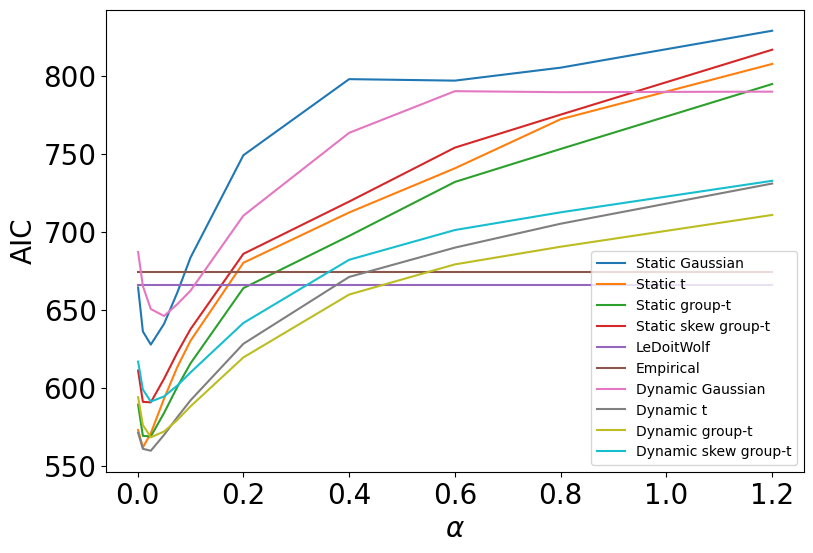

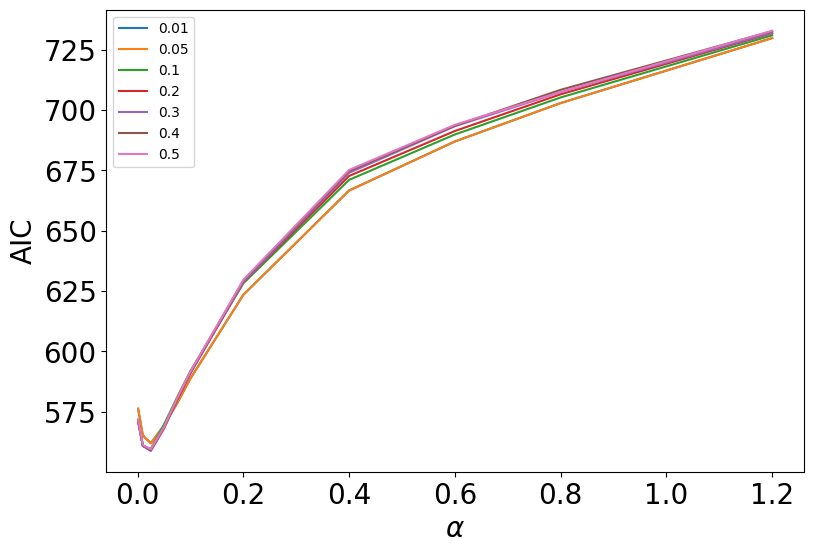

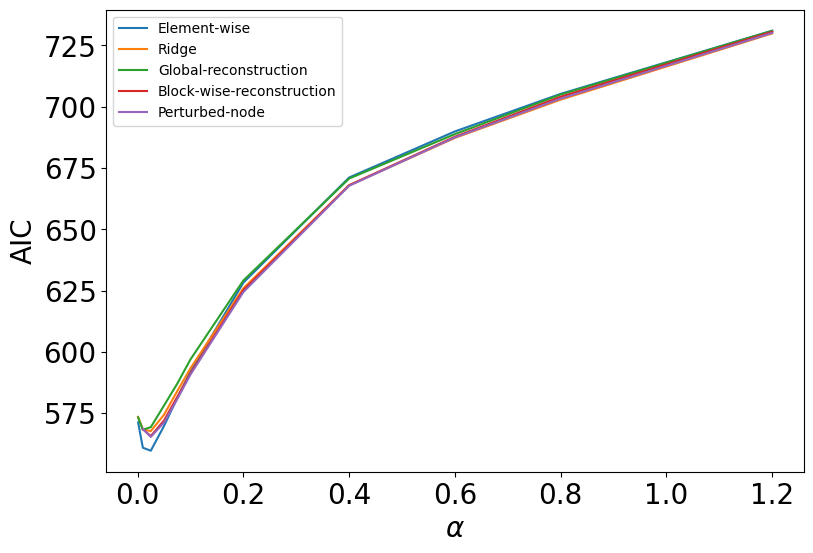

In [7]:
k = str(0.1)


fig, ax = plt.subplots(1,1, figsize = (9,6))
var_agg, var_agg_std = plot_stat('future_AIC', [sgaussian, st, sgt, ssgt, ledoitwolf, empirical, dgaussian_ew[k], dt_ew[k],  dgt_ew[k], dsgt_ew[k]], 
                                 ['Static Gaussian', 'Static t', 'Static group-t', 'Static skew group-t', 'LeDoitWolf', 'Empirical', 'Dynamic Gaussian', 'Dynamic t', 'Dynamic group-t', 'Dynamic skew group-t'], ax = ax)
ax.set_title("")
ax.set_ylabel("AIC", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'lower right')

# fig, ax = plt.subplots(1,1, figsize = (9,6))
# var_agg, var_agg_std = plot_stat('future_AIC', [dgaussian_ew[k],dt_ew[k], dgt_ew[k], dsgt_ew[k] ], 
#                                  ['Dynamic Gaussian', 'Dynamic t',  'Dynamic group t', 'Dynamic skew group t'], ax = ax)
# ax.set_title("")
# ax.set_ylabel("AIC", fontdict = {'fontsize':20})
# ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
# ax.tick_params(axis='both', which='major', labelsize=20)
# ax.legend(loc = 'upper left')




fig, ax = plt.subplots(1,1, figsize = (9,6))
var_agg, var_agg_std = plot_stat('future_AIC', [dt_ew[str(0.01)], dt_ew[str(0.01)], dt_ew[str(0.1)],dt_ew[str(0.2)],dt_ew[str(0.3)],dt_ew[str(0.4)],dt_ew[str(0.5)] ], 
                                 ['0.01', '0.05','0.1', '0.2', '0.3', '0.4', '0.5'], ax = ax)
ax.set_title("")
ax.set_ylabel("AIC", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper left')



k = str(0.1)
fig, ax = plt.subplots(1,1, figsize = (9,6))
var_agg, var_agg_std = plot_stat('future_AIC', [dt_ew[k], dt_ridge[k], dt_gr[k], dt_bwr[k], dt_pn[k]], 
                                 ['Element-wise', 'Ridge', 'Global-reconstruction', 'Block-wise-reconstruction', 'Perturbed-node'], ax = ax)
ax.set_title("")
ax.set_ylabel("AIC", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper left')

## Plot Nr params

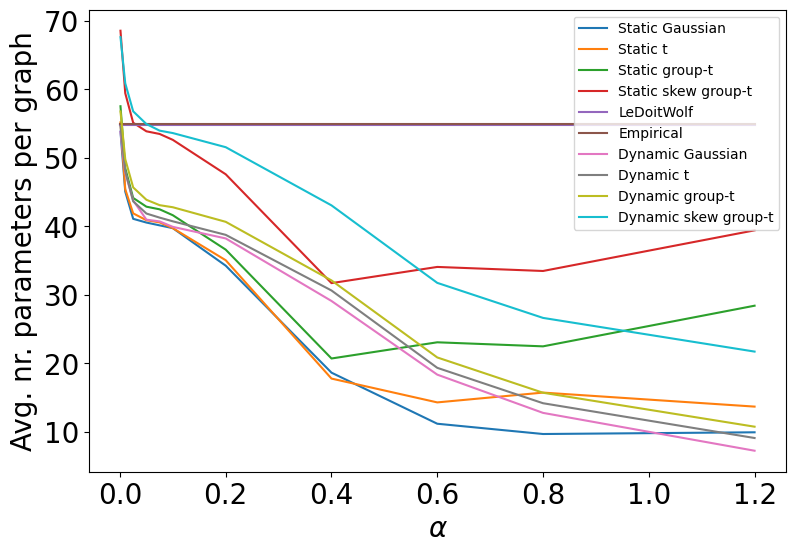

In [8]:
fig, ax = plt.subplots(1,1, figsize = (9,6))
k = str('0.1')
var_agg, var_agg_std = plot_stat('nr_params', [sgaussian, st, sgt, ssgt, ledoitwolf, empirical, dgaussian_ew[k], dt_ew[k],  dgt_ew[k], dsgt_ew[k]], 
                                 ['Static Gaussian', 'Static t', 'Static group-t', 'Static skew group-t', 'LeDoitWolf', 'Empirical', 'Dynamic Gaussian', 'Dynamic t', 'Dynamic group-t', 'Dynamic skew group-t'], ax = ax)
ax.set_title("")
ax.set_ylabel("Avg. nr. parameters per graph", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper right')




## Plot number of changes through time

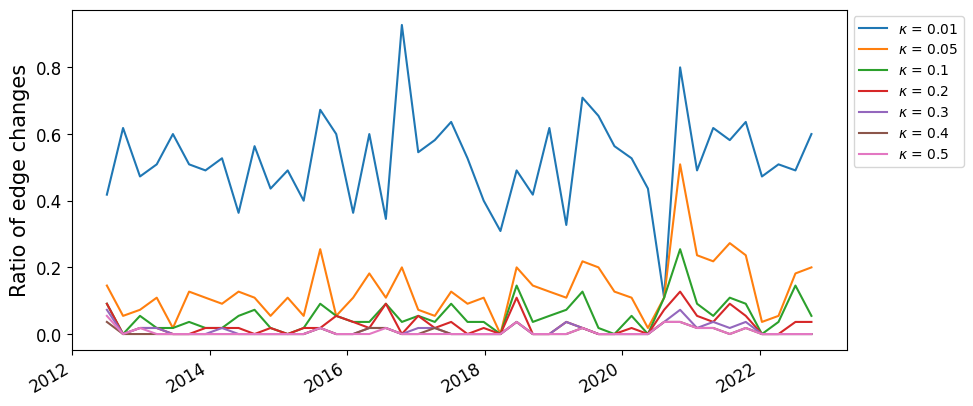

In [9]:
def nr_diff_elements(x,y,tol = 1e-1):
    A = x[np.triu_indices(x.shape[0], 1)]-y[np.triu_indices(x.shape[0], 1)]
    return np.sum(np.abs(A)>1e-2)

k = str(0.5)
nr_diff_elements_arr = np.zeros((len(dt_ew), len(dt_ew[k]['thetas']), len(dt_ew[k]['thetas'][0])))

for k, key in enumerate(dt_ew.keys()):
    for i in range(nr_diff_elements_arr.shape[1]):
        for j in range(nr_diff_elements_arr.shape[2]):
            #nr_diff_elements_arr[k,i,j] = np.sum([np.linalg.norm(dt_ew[key]['thetas'][i][j][s+1]-dt_ew[key]['thetas'][i][j][s]) for s in range(1)])
            nr_diff_elements_arr[k,i,j] = np.sum([np.abs(dt_ew[key]['thetas'][i][j][s+1])-np.abs(dt_ew[key]['thetas'][i][j][s] ) > 0.1 for s in range(1)])

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k, key in enumerate(dt_ew.keys()):
    ax.plot(dt_ew[key]['time_change'], nr_diff_elements_arr[k,-2]/(11*10/2),label = r'$\kappa$ = ' + str(key) )
ax.set_ylabel("Ratio of edge changes", fontdict = {'fontsize':15})
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
#ax.xaxis.set_tick_params(rotation=45)
ax.legend(bbox_to_anchor = (1,1))
ax.tick_params(axis='both', which='major', labelsize=12)

## Plot portfolio statistics




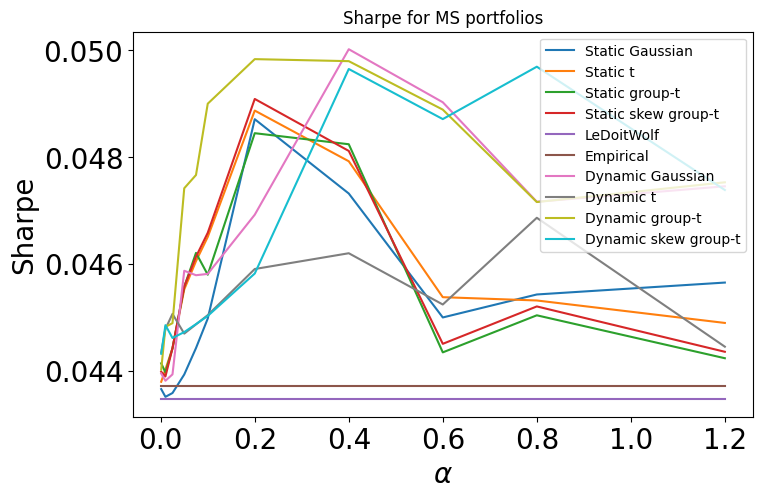

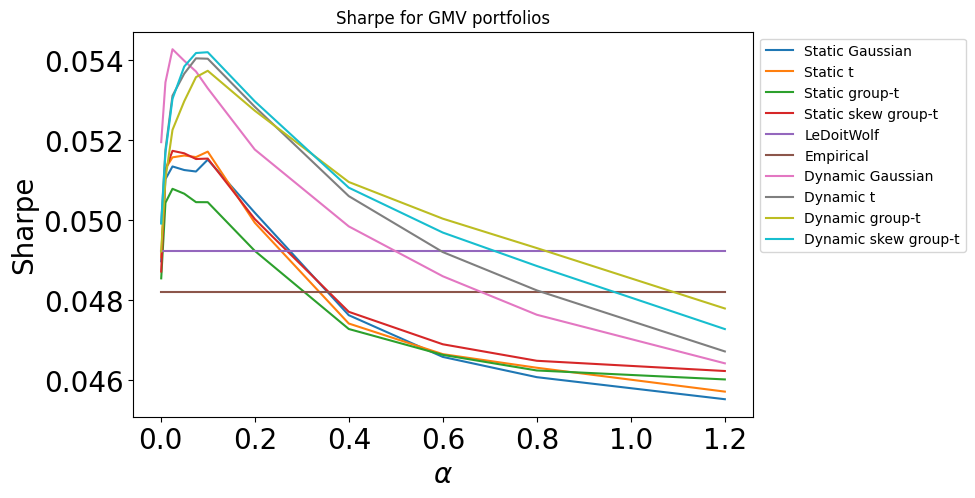

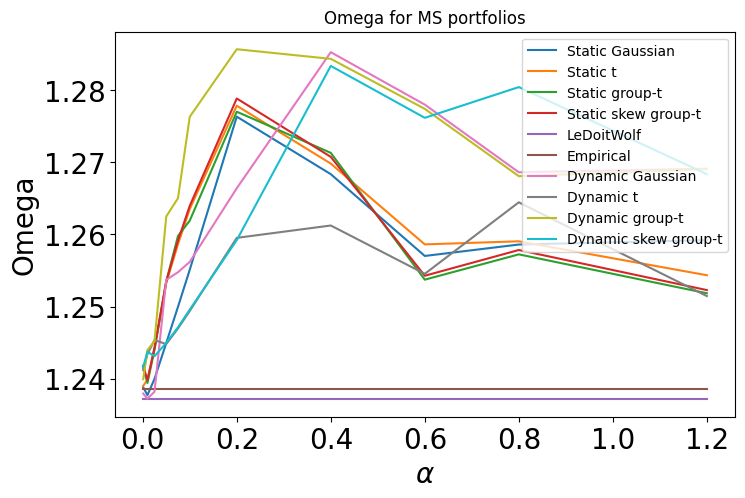

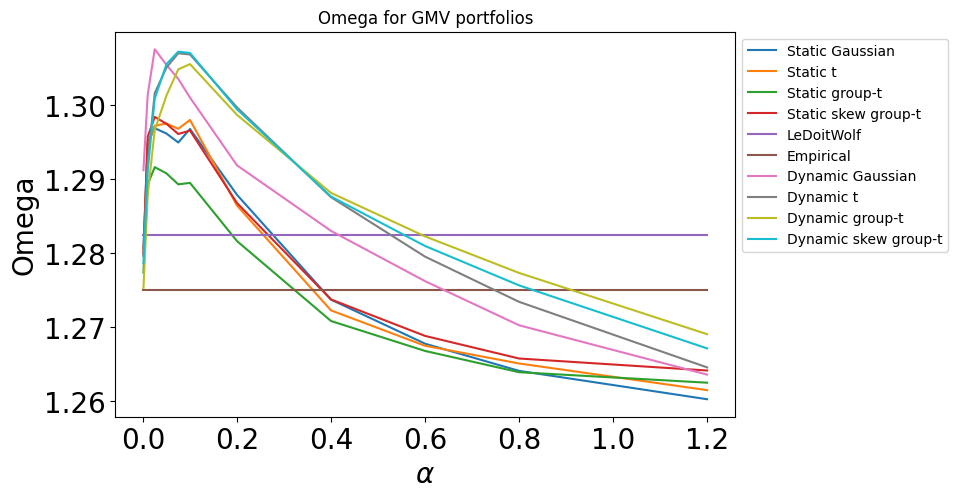

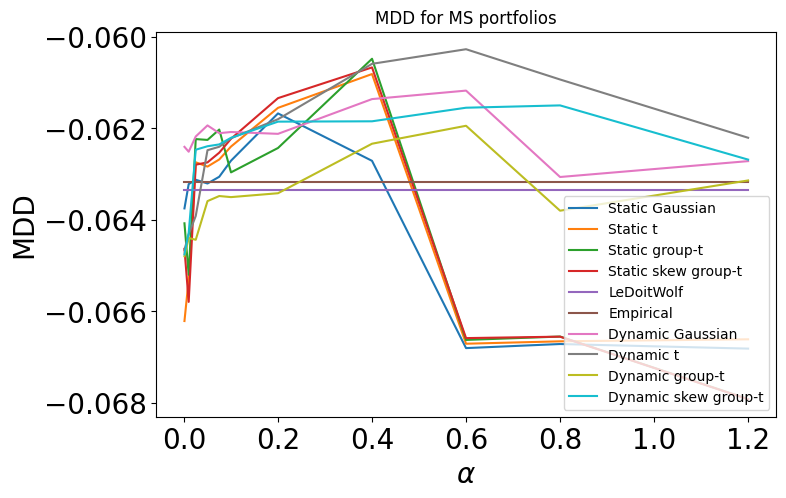

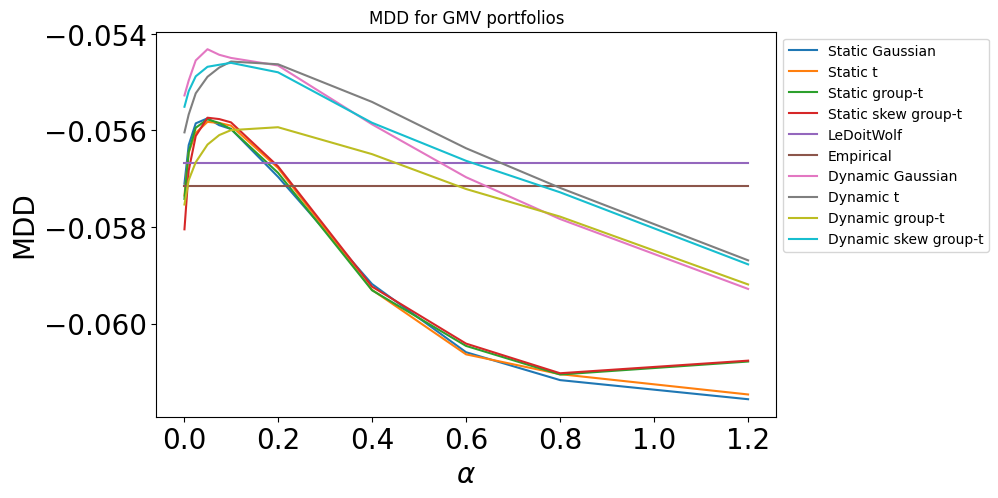

In [33]:
k = str(0.1)
args = [sgaussian, st, sgt, ssgt, ledoitwolf, empirical, dgaussian_ew[k], dt_ew[k], dgt_ew[k], dsgt_ew[k]]
labels = ['Static Gaussian', 'Static t', 'Static group-t', 'Static skew group-t', 'LeDoitWolf', 'Empirical', 'Dynamic Gaussian', 'Dynamic t', 'Dynamic group-t', 'Dynamic skew group-t']
fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('sharpes_s', args, 
                                 labels, ax = ax)
ax.set_title("Sharpe for MS portfolios")
ax.set_ylabel("Sharpe", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()

fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('sharpes_m', args, 
                                 labels, ax = ax)
ax.set_title("Sharpe for GMV portfolios")
ax.set_ylabel("Sharpe", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(bbox_to_anchor = (1,1))

fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('omegas_s', args, 
                                 labels, ax = ax)
ax.set_title("Omega for MS portfolios")
ax.set_ylabel("Omega", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()

fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('omegas_m', args, 
                                 labels, ax = ax)
ax.set_title("Omega for GMV portfolios")
ax.set_ylabel("Omega", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(bbox_to_anchor = (1,1))

fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('mdds_s', args, 
                                 labels, ax = ax)
ax.set_title("MDD for MS portfolios")
ax.set_ylabel("MDD", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()



fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('mdds_m', args, 
                                 labels, ax = ax)
ax.set_title("MDD for GMV portfolios")
ax.set_ylabel("MDD", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(bbox_to_anchor = (1,1))


## Price processes

In [3]:
import yfinance as yf

ticker_list = ['^GSPC']
groups = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
start_date= "2012-07-01"
end_date="2023-02-01"

data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]
def cum_prod_port(x):
    return np.cumprod(np.concatenate([(1+pd.DataFrame(x[i]).pct_change()).dropna() for i in range(len(x))]))

[*********************100%***********************]  1 of 1 completed


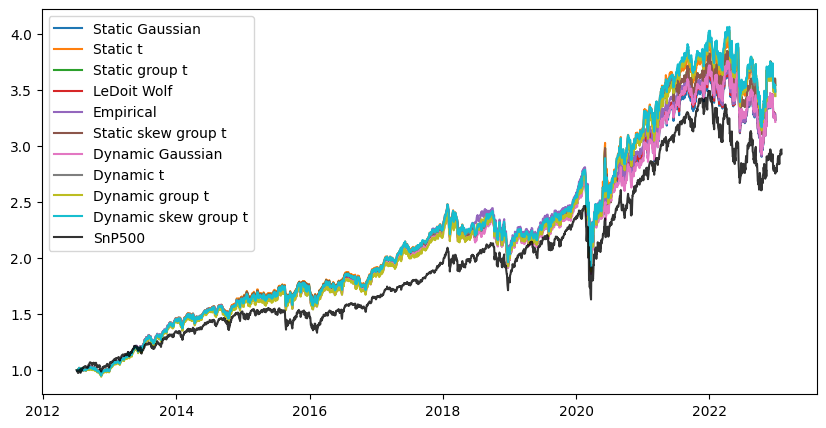

In [24]:
def cum_prod_port(x):
    #return ([np.cumprod((1+pd.DataFrame(x[i]).pct_change()).dropna()) for i in range(len(x))][0]).cumprod()
    return np.cumprod(np.concatenate([(1+pd.DataFrame(x[i]).pct_change()).dropna() for i in range(len(x))]))


#static_gaussian_port_info, static_t_port_info, static_gt_port_info, d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4']

s_n_price = cum_prod_port(sgaussian['port_price_s'][9])  #np.cumprod(1+np.array(static_t_port_info['rs_s'][3]))# 
s_t_price = cum_prod_port(st['port_price_s'][9]) 
s_gt_price = cum_prod_port(sgt['port_price_s'][9]) 
s_sgt_price = cum_prod_port(ssgt['port_price_s'][9]) 
lewolf_price = cum_prod_port(ledoitwolf['port_price_s'][9]) 
emp_price = cum_prod_port(empirical['port_price_s'][9]) 
d_n_price = cum_prod_port(dgaussian_ew['0.1']['port_price_s'][9])  #np.cumprod(1+np.array(static_t_port_info['rs_s'][3]))# 
d_t_price = cum_prod_port(dt_ew['0.1']['port_price_s'][9]) 
d_gt_price = cum_prod_port(dgt_ew['0.1']['port_price_s'][9]) 
d_sgt_price = cum_prod_port(dsgt_ew['0.1']['port_price_s'][9]) 


#price = price.loc[np.isin(price.index)]

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]), s_n_price, label = 'Static Gaussian')
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]),s_t_price, label = 'Static t')
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]),s_gt_price, label = 'Static group t')
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]),lewolf_price, label = 'LeDoit Wolf')
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]),emp_price, label = 'Empirical')
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]),s_gt_price, label = 'Static skew group t')
ax.plot(np.concatenate([dt[1:] for dt in dt_ew['0.4']['time_forecast'][0]]),d_n_price, label = 'Dynamic Gaussian')
ax.plot(np.concatenate([dt[1:] for dt in dt_ew['0.4']['time_forecast'][0]]),d_t_price, label = 'Dynamic t')
ax.plot(np.concatenate([dt[1:] for dt in dt_ew['0.4']['time_forecast'][0]]),d_gt_price, label = 'Dynamic group t')
ax.plot(np.concatenate([dt[1:] for dt in dt_ew['0.4']['time_forecast'][0]]),d_sgt_price, label = 'Dynamic skew group t')
ax.plot((1+price.pct_change()).index, np.cumprod(1+price.pct_change()), label = 'SnP500', color = 'black', alpha = 0.8)
ax.legend()

# Pension funded vs unfunded

Read GDP

<Axes: xlabel='observation_date'>

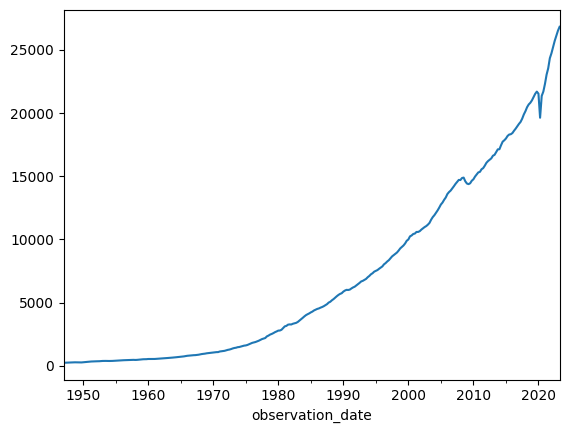

In [17]:
gdp = pd.read_excel("../data/GDP.xls",)
gdp.head()
gdp.index = gdp['observation_date']
gdp = gdp.iloc[:,1]
gdp.plot()

<Axes: xlabel='observation_date'>

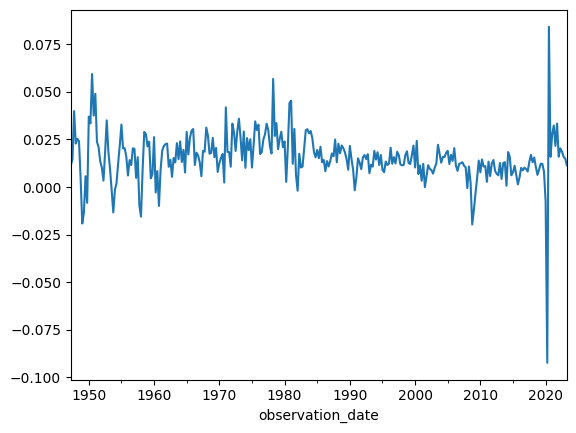

In [18]:
log_rgdp = np.log((1+gdp.pct_change())).dropna()
log_rgdp.plot() ## quarterly change

In [19]:
np.std(log_rgdp.iloc[300-100:300])*4

0.05894997601197678

Join daily dates and make daily return

<Axes: >

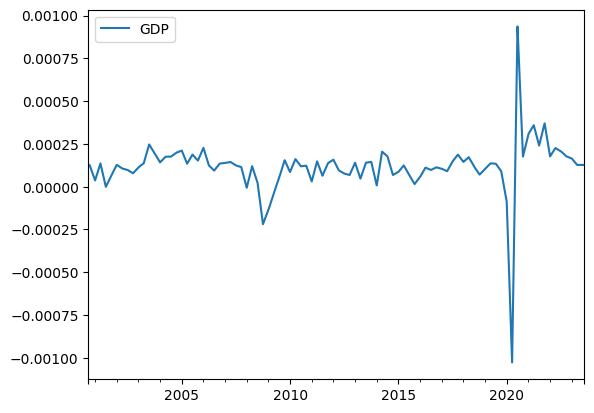

In [20]:
date_df = pd.DataFrame( index = pd.date_range(start="2000-09-09",end="2023-08-02"))
daily_log_rgdp = pd.merge(date_df,log_rgdp, left_index=True, right_index=True,  how = 'left')
daily_log_rgdp = daily_log_rgdp.interpolate()/90
daily_log_rgdp.plot()

In [21]:
with open(f'data/raw_etf2.pkl', 'rb') as handle:
    data = pickle.load(handle)

ticker_list = data['ticker_list']
log_returns_scaled = data['log_returns_scaled']
price = data['price']
groups = data['groups']


In [22]:


def fund_weights(obj, gamma, a_idx, log_rgdp):

    gdp_mu = []
    mu_r = []
    std_r = []
    gdp_std = []
    covar = []
    w_dew = []
    stds = log_rgdp.rolling(40).std()
    means = log_rgdp.rolling(40).mean()
    for cnt, (t,j) in enumerate(zip(obj['time_change'], obj['time_index'])):
        if cnt <=1:
            continue
        i = np.where(log_rgdp.index == min(log_rgdp.index, key=lambda d: abs(d-t)))[0][0] -1
        gdp_returns = daily_log_rgdp.iloc[i-40:i,0]
        gdp_mu.append(means[i]*4*100) ## annualized
        gdp_std.append(stds[i]*np.sqrt(4)*100 ) ## annualized


        w_s = obj['ws_s'][a_idx][cnt]
        past_price = np.dot(price.iloc[j-180:j],w_s)
        log_returns = np.array(np.log(1+pd.DataFrame(past_price).pct_change()).dropna())[:,0]
        mu_r.append(np.mean(log_returns)*250*100)
        std_r.append(np.std(log_returns)*np.sqrt(250)*100)

        
        past_price = price.iloc[j-60*6:j:60]
        log_returns = np.array(np.log(1+pd.DataFrame(past_price).pct_change()).dropna())[:,0]*100
        covar.append(np.cov((log_returns, np.array(log_rgdp.iloc[i-5:i])))[0,1])



    for i in range(len(covar)):
        w_dew.append((mu_r[i] - gdp_mu[i] + gamma*(gdp_std[i]**2 -covar[i] ) )/(gamma*(std_r[i]**2 + gdp_std[i]**2 - 2*covar[i])))

    return w_dew, gdp_mu, gdp_std,covar, mu_r, std_r

In [23]:
yc = pd.read_pickle("../CovRegressionPaper/yc/US.pkl")
spread = yc['10 Yr'].loc[(yc['2 Yr'] != '') & (yc['10 Yr'] != '')].astype(float) - yc['2 Yr'].loc[(yc['2 Yr'] != '') & (yc['10 Yr'] != '')].astype(float)
spread_time = pd.to_datetime(yc['Date'].loc[(yc['2 Yr'] != '') & (yc['10 Yr'] != '')])

In [24]:
import yfinance as yf

ticker_list = ['^VIX']
start_date= "2012-07-01"
end_date="2023-02-01"

VIX = yf.download(ticker_list, start_date , end_date)

[*********************100%***********************]  1 of 1 completed


In [25]:
ffinterest = pd.read_csv("../CovRegressionPaper/yc/FederalInterest.csv")

In [26]:
ffinterest.index = pd.to_datetime(ffinterest['Date'])

(15700.0, 19269.0)

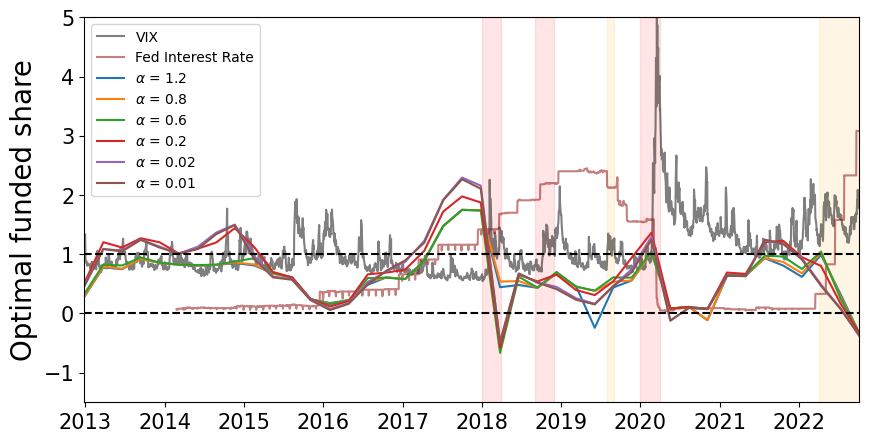

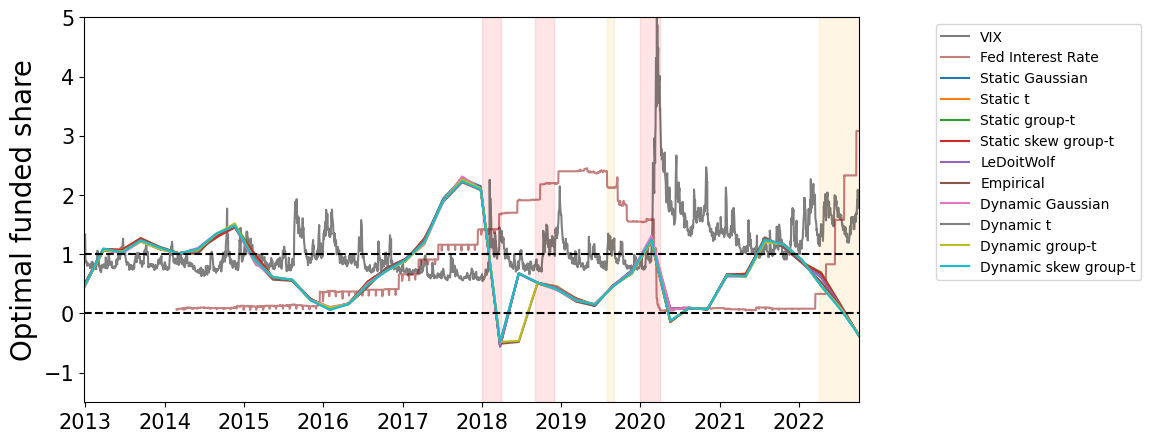

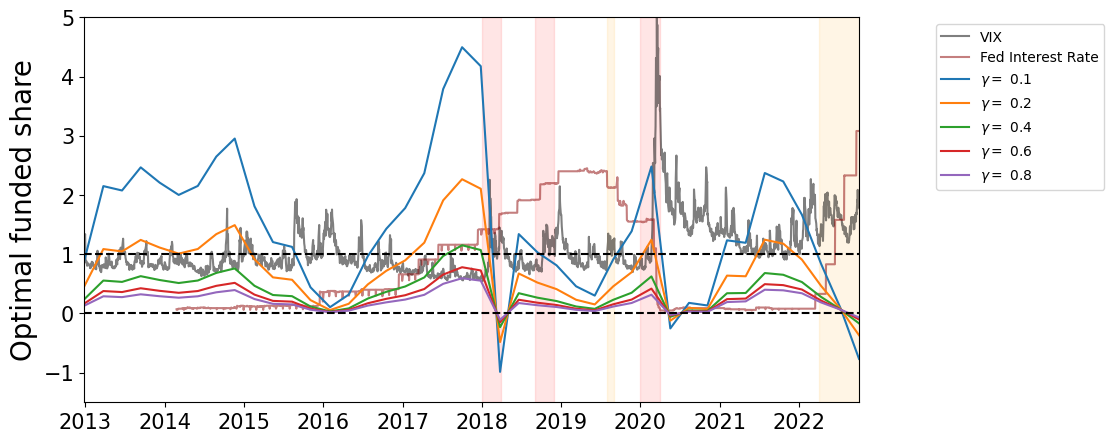

In [34]:




# Plot per alpha
fig, ax = plt.subplots(1,1, figsize = (10,5))
# ax.plot(spread_time.iloc[100:3000], spread.iloc[100:3000], alpha = 0.5, label = 'Spread')
ax.plot(VIX.index, 5*VIX['Open']/np.max(VIX['Open']), alpha = 0.5, label = 'VIX', color = 'black')
ax.plot(ffinterest.index, ffinterest['Open'], alpha = 0.5, label = 'Fed Interest Rate', color = 'darkred')

#ax.fill_between(pd.to_datetime(["2018-9-01", "2018-9-01"]), [-1 ,5], linestyle = '--')
#ax.plot(pd.to_datetime(["2018-12-01", "2018-9-01"]), [-1 ,5], linestyle = '--')
ax.axvspan(pd.to_datetime(["2018-01-01"])[0], pd.to_datetime(["2018-03-30"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2018-9-01"])[0], pd.to_datetime(["2018-12-01"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2020-01-01"])[0], pd.to_datetime(["2020-04-01"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2019-08-01"])[0], pd.to_datetime(["2019-09-01"])[0], alpha=0.1, color='orange')
ax.axvspan(pd.to_datetime(["2022-04-01"])[0], pd.to_datetime(["2023-09-01"])[0], alpha=0.1, color='orange')

for a_idx in [0, 1, 2, 4, 8, 9]:
    w, gdp_mu, gdp_std,covar, mu_r, std_r = fund_weights(dt_ew['0.1'], 0.2, a_idx, log_rgdp)
    ax.plot(dt_ew['0.01']['time_change'][2:], w, label = r'$\alpha$ = ' + str(np.round(dt_ew['0.1']['alphas'][a_idx], 2)))


ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
ax.set_ylim((-1.5, 5))
ax.legend(loc = 'upper left', fontsize = 10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel("Optimal funded share", fontdict = {'fontsize':20})
ax.set_xlim((np.min(dt_ew['0.01']['time_change'][2:]), np.max(dt_ew['0.01']['time_change'][2:])))


# plot per model 
k = str(0.1)
models = [sgaussian, st, sgt, ssgt, ledoitwolf, empirical, dgaussian_ew[k], dt_ew[k],  dgt_ew[k], dsgt_ew[k]]
labels = ['Static Gaussian', 'Static t', 'Static group-t', 'Static skew group-t', 'LeDoitWolf', 'Empirical', 'Dynamic Gaussian', 'Dynamic t', 'Dynamic group-t', 'Dynamic skew group-t']
fig, ax = plt.subplots(1,1, figsize = (10,5))

# ax.plot(spread_time.iloc[100:3000], spread.iloc[100:3000], alpha = 0.5, label = 'Spread')
ax.plot(VIX.index, 5*VIX['Open']/np.max(VIX['Open']), alpha = 0.5, label = 'VIX', color = 'black')
ax.plot(ffinterest.index, ffinterest['Open'], alpha = 0.5, label = 'Fed Interest Rate', color = 'darkred')

#ax.fill_between(pd.to_datetime(["2018-9-01", "2018-9-01"]), [-1 ,5], linestyle = '--')
#ax.plot(pd.to_datetime(["2018-12-01", "2018-9-01"]), [-1 ,5], linestyle = '--')
ax.axvspan(pd.to_datetime(["2018-01-01"])[0], pd.to_datetime(["2018-03-30"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2018-9-01"])[0], pd.to_datetime(["2018-12-01"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2020-01-01"])[0], pd.to_datetime(["2020-04-01"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2019-08-01"])[0], pd.to_datetime(["2019-09-01"])[0], alpha=0.1, color='orange')
ax.axvspan(pd.to_datetime(["2022-04-01"])[0], pd.to_datetime(["2023-09-01"])[0], alpha=0.1, color='orange')


for cnt  in range(len(models)):
    w, gdp_mu, gdp_std,covar, mu_r, std_r = fund_weights(models[cnt], 0.2 , 9, log_rgdp)
    ax.plot(dt_ew['0.01']['time_change'][2:], w, label = labels[cnt] )
ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
ax.set_ylim((-1.5, 5))
ax.legend(bbox_to_anchor = (1.09,1), fontsize = 10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel("Optimal funded share", fontdict = {'fontsize':20})
ax.set_xlim((np.min(dt_ew['0.01']['time_change'][2:]), np.max(dt_ew['0.01']['time_change'][2:])))

# Plot per gamma
fig, ax = plt.subplots(1,1, figsize = (10,5))


# ax.plot(spread_time.iloc[100:3000], spread.iloc[100:3000], alpha = 0.5, label = 'Spread')
ax.plot(VIX.index, 5*VIX['Open']/np.max(VIX['Open']), alpha = 0.5, label = 'VIX', color = 'black')
ax.plot(ffinterest.index, ffinterest['Open'], alpha = 0.5, label = 'Fed Interest Rate', color = 'darkred')

#ax.fill_between(pd.to_datetime(["2018-9-01", "2018-9-01"]), [-1 ,5], linestyle = '--')
#ax.plot(pd.to_datetime(["2018-12-01", "2018-9-01"]), [-1 ,5], linestyle = '--')
ax.axvspan(pd.to_datetime(["2018-01-01"])[0], pd.to_datetime(["2018-03-30"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2018-9-01"])[0], pd.to_datetime(["2018-12-01"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2020-01-01"])[0], pd.to_datetime(["2020-04-01"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2019-08-01"])[0], pd.to_datetime(["2019-09-01"])[0], alpha=0.1, color='orange')
ax.axvspan(pd.to_datetime(["2022-04-01"])[0], pd.to_datetime(["2023-09-01"])[0], alpha=0.1, color='orange')


for gamma  in [0.1,0.2,0.4,0.6, 0.8]:
    w, gdp_mu, gdp_std,covar, mu_r, std_r = fund_weights( dt_ew[str(0.1)], gamma , 9, log_rgdp)
    ax.plot(dt_ew['0.01']['time_change'][2:], w, label = r'$\gamma = $ ' + str(gamma) )
ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
ax.set_ylim((-1.5, 5))
ax.legend(bbox_to_anchor = (1.09,1), fontsize = 10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel("Optimal funded share", fontdict = {'fontsize':20})
ax.set_xlim((np.min(dt_ew['0.01']['time_change'][2:]), np.max(dt_ew['0.01']['time_change'][2:])))

# # plot per kappa 
# fig, ax = plt.subplots(1,1, figsize = (10,5))
# for k_idx, k in enumerate(dt_ew.keys()):
#     w, gdp_mu, gdp_std,covar, mu_r, std_r = fund_weights(dt_ew[k], 0.2 , 9, log_rgdp)
#     ax.plot(dt_ew['0.01']['time_change'][2:], w, label = r'$\kappa$ = ' + list(dt_ew.keys())[k_idx] )

# ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.set_ylabel("Optimal funded share")
# ax.legend()



# ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.set_ylabel("Optimal funded share")
# ax.legend()


# plot per penalty 
# k = str(0.1)
# models = [dt_ew[k], dt_ridge[k], dt_gr[k], dt_bwr[k], dt_pn[k]]
# labels = ['Element-wise', 'Ridge', 'Global-reconstruction', 'Block-wise-reconstruction', 'Perturbed-node']
# fig, ax = plt.subplots(1,1, figsize = (10,5))
# for cnt  in range(len(models)):
#     w, gdp_mu, gdp_std,covar, mu_r, std_r = fund_weights(models[cnt], 0.2 , 9, log_rgdp)
#     ax.plot(dt_ew['0.01']['time_change'][2:], w, label = labels[cnt] )

# ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.set_ylabel("Optimal funded share")
# ax.legend()


# k = str(0.1)
# models = [dt_ew['0.1'], dt_ew['0.4']]
# labels = ['Element-wise', 'Ridge', 'Global-reconstruction', 'Block-wise-reconstruction', 'Perturbed-node']
# fig, ax = plt.subplots(1,1, figsize = (10,5))
# for cnt  in range(len(models)):
#     w, gdp_mu, gdp_std,covar, mu_r, std_r = fund_weights(models[cnt], 0.2 , 9, log_rgdp)
#     ax.plot(dt_ew['0.01']['time_change'][2:], w, label = labels[cnt] )

# ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.set_ylabel("Optimal funded share")
# ax.legend()


# fig, ax = plt.subplots(1,1, figsize = (10,5))
# ax.plot(dt_ew['0.01']['time_change'][2:],gdp_mu, label = 'mean gdp')
# ax.plot(dt_ew['0.01']['time_change'][2:],mu_r, label = 'Portfolio mean')
# ax.set_title("Mean")
# ax.legend()


# fig, ax = plt.subplots(1,1, figsize = (10,5))
# ax.plot(dt_ew['0.01']['time_change'][2:], gdp_std, label = 'gdp std')
# ax.plot(dt_ew['0.01']['time_change'][2:], std_r, label = 'Portfolio std')
# ax.plot(dt_ew['0.01']['time_change'][2:], covar, label = 'Covariance')

# ax.set_title("std")
# ax.legend()





